In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision.transforms import ToTensor
import os 
from sklearn.model_selection import train_test_split
import shutil
import matplotlib.pyplot as plt
import time
import torch.optim as optim
import numpy as np
import torchvision
from torch.cuda import device    
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")
#from torch.optim import lr_schedule

In [ ]:
import zipfile
with zipfile.ZipFile('/content/FER2013.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/mydataset')

In [ ]:
# Define transformations for the dataset
image_size=(224,224)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5]),
])

transform_test = transforms.Compose([
    transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5]),
])

In [ ]:
# Define the data loaders
# Load the dataset
train_dataset = datasets.ImageFolder(root='/content/mydataset/FER2013/train', transform=transform_train)
val_dataset = datasets.ImageFolder(root='/content/mydataset/FER2013/validation', transform=transform_train)
test_dataset = datasets.ImageFolder(root='/content/mydataset/FER2013/test', transform=transform_test)

# Define the data loaders
train_loader = DataLoader(train_dataset, batch_size=32,shuffle=True, drop_last=False,num_workers=0)
val_loader = DataLoader(train_dataset, batch_size=32,shuffle=False, drop_last=False,num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32,shuffle=False, drop_last=False,num_workers=0)

In [ ]:
def plot_data_loader(data_loader, gridDims):
    
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, _ = next(dataiter)
            axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

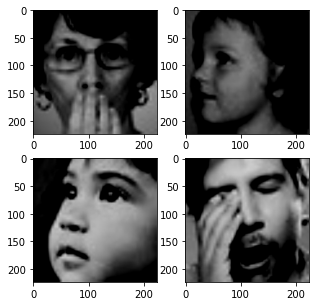

In [ ]:
plot_data_loader(train_loader, (2, 2))

In [ ]:
train_size = len(train_dataset)
test_size = len(test_dataset)
val_size = len(val_dataset)
print("Train Size:",train_size)
print("Test Size:",test_size)
print("Validation Size:",val_size)

Train Size: 3208
Test Size: 1020
Validation Size: 809


In [ ]:
num_classes = len(train_dataset.classes)
print("Number of classes:", num_classes)

Number of classes: 3


In [ ]:
torch.cuda.empty_cache()

In [ ]:
model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model.to(device);

Device: cuda:0


Epoch [1/25], Step [10/101], Loss: 1.9890, Accuracy: 35.00%, Validation Accuracy: 32.95%
Epoch [1/25], Step [20/101], Loss: 1.5778, Accuracy: 34.06%, Validation Accuracy: 33.48%
Epoch [1/25], Step [30/101], Loss: 1.4222, Accuracy: 36.56%, Validation Accuracy: 35.88%
Epoch [1/25], Step [40/101], Loss: 1.3432, Accuracy: 36.56%, Validation Accuracy: 36.91%
Epoch [1/25], Step [50/101], Loss: 1.2945, Accuracy: 36.00%, Validation Accuracy: 37.53%
Epoch [1/25], Step [60/101], Loss: 1.2594, Accuracy: 36.77%, Validation Accuracy: 41.21%
Epoch [1/25], Step [70/101], Loss: 1.2353, Accuracy: 37.01%, Validation Accuracy: 42.14%
Epoch [1/25], Step [80/101], Loss: 1.2145, Accuracy: 37.62%, Validation Accuracy: 37.09%
Epoch [1/25], Step [90/101], Loss: 1.2012, Accuracy: 37.81%, Validation Accuracy: 37.66%
Epoch [1/25], Step [100/101], Loss: 1.1886, Accuracy: 37.72%, Validation Accuracy: 42.64%
Epoch [2/25], Step [10/101], Loss: 1.0904, Accuracy: 40.94%, Validation Accuracy: 39.46%
Epoch [2/25], Step [

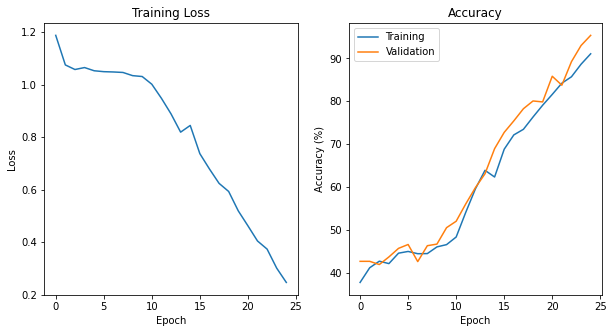

In [ ]:
import matplotlib.pyplot as plt

# Initialize lists to store loss and accuracy values
train_losses, train_accs, val_accs = [], [], []

# Define number of epochs and total steps
num_epochs = 25
total_steps = len(train_loader)

t1 = time.time()

# Train loop
for epoch in range(num_epochs):
    # Initialize loss and accuracy variables for each epoch
    train_loss, train_total, train_correct = 0, 0, 0
    
    for i, data in enumerate(train_loader):
        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backprop and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate training loss and accuracy
        train_loss += loss.item()
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += total
        
        if (i + 1) % 10 == 0:
            # Calculate validation accuracy
            correct_v = 0
            total_v = 0
            for dataVal in val_loader:
                images_v, labels_v = dataVal[0].to(device), dataVal[1].to(device)
                outputs = model(images_v)
                _, predicted = torch.max(outputs.data, 1)
                correct_v += (predicted == labels_v).sum().item()
                total_v += labels_v.size(0)
            
            # Print training and validation loss and accuracy values
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs, i + 1, total_steps, train_loss / (i+1),
                    (train_correct / train_total) * 100, (correct_v / total_v) * 100))

    # Store loss and accuracy values for this epoch
    train_losses.append(train_loss / (i+1))
    train_accs.append((train_correct / train_total) * 100)
    val_accs.append((correct_v / total_v) * 100)

# Print total training time
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

# Plot loss and accuracy graphs
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].plot(train_losses)
ax[0].set_title("Training Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")

ax[1].plot(train_accs, label="Training")
ax[1].plot(val_accs, label="Validation")
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy (%)")
ax[1].legend()

plt.show()


Test Accuracy of the model on the 1020 test images: 71.76470588235294 %


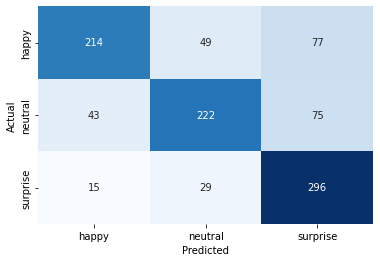

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_predicted += predicted.tolist()
        all_labels += labels.tolist()

    print('Test Accuracy of the model on the {} test images: {} %'
          .format(total, (correct / total) * 100))

    cm = confusion_matrix(all_labels, all_predicted)
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                     xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')


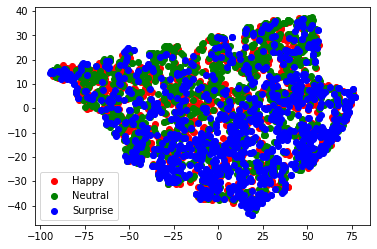

In [ ]:
import torch
import torchvision.models as models
from torchvision import transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Define the label names and associated colors
label_names = ['Happy', 'Neutral', 'Surprise']
colors = ['r', 'g', 'b']

# Load the ResNet18 model with pretrained weights
resnet18 = models.resnet18(pretrained=False)

# Remove the last layer (softmax classifier) of the model
resnet18 = torch.nn.Sequential(*list(resnet18.children())[:-1])

# Set the model to evaluation mode
resnet18.eval()

# Extract features from the convolutional layers of the model for all images in the train dataset
features = []
labels = []
with torch.no_grad():
    for images, target in train_loader:
        # Pass the images through the model to extract features
        outputs = resnet18(images)
        # Flatten the features to a 2D array
        features.append(outputs.view(outputs.size(0), -1).numpy())
        # Save the corresponding labels
        labels.append(target.numpy())
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# Apply t-SNE to reduce the dimensionality of the features to 2D
tsne = TSNE(n_components=2, random_state=0)
tsne_features = tsne.fit_transform(features)

# Plot the t-SNE graph with a legend
for label_id in range(len(label_names)):
    plt.scatter(tsne_features[labels == label_id, 0], tsne_features[labels == label_id, 1], c=colors[label_id], label=label_names[label_id])
plt.legend()
plt.show()

